# Assignment 1
**Emma McCready**

---

### Analysis of population over time

You are required to collect, process, analyse and interpret the data in order to identify possible issues/problems at present and make predictions/classifications in regard to the future. This analysis will rely on the available data from CSO and any additional data you deem necessary (with supporting evidence) to support your hypothesis for this scenario.

Areas of focus:
* Annual Population Change
* Population Forecasting

To do:

* Re organise this sheet into Data Cleaning, then Data prep (if this is the correct order?), then EDA... and so on
* Maybe write a function to automatically prepare the data for each type of migration?
* I'd rather if net migration included the thousands in it
* Investigate "All countries" under countries dataset

--- 

- diagnosing the “tidiness” of the data — how much data cleaning we will have to do
- reshaping the data — getting right rows and columns for effective analysis
- combining multiple files
- changing the types of values — how we fix a column where numerical values are stored as strings, for example
- dropping or filling missing values - how we deal with data that is incomplete or missing
- manipulating strings to represent the data better

https://www.cso.ie/en/releasesandpublications/ep/p-pme/populationandmigrationestimatesapril2023/keyfindings/

In [1]:
# Dependencies.. put any packages I install here:
#!pip install pandas==2.1.2
#!pip install ydata_profiling --user

In [2]:
# had to run the following, as plots weren't showing in my codebook - found this solution after some troubleshooting
#%matplotlib notebook 
%matplotlib inline

In [3]:
# Load in packages

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') 


<summary style="color:blue;">

# 1. Data Inspection
    
First, I need to load in the data, and then take a quick look at the data to get a sense of what I'm dealing with. I'm initially interested in what unique columns there are, the data types of the columns,

In [4]:
pop_data = pd.read_csv("migration_data.csv")


pop_data.head()
#pop_data.tail()

,STATISTIC Label,Year,Country,Sex,Origin or Destination,UNIT,VALUE
0,Estimated Migration (Persons in April),1987,United Kingdom (1),Both sexes,Net migration,Thousand,-13.7
1,Estimated Migration (Persons in April),1987,United Kingdom (1),Both sexes,Emigrants: All destinations,Thousand,21.8
2,Estimated Migration (Persons in April),1987,United Kingdom (1),Both sexes,Immigrants: All origins,Thousand,8.1
3,Estimated Migration (Persons in April),1987,United Kingdom (1),Male,Net migration,Thousand,-9.0
4,Estimated Migration (Persons in April),1987,United Kingdom (1),Male,Emigrants: All destinations,Thousand,13.1


<summary style="color:blue;">

__Notes on the above:__

the dataframe is already in a good format, in that it has each variable as a separate column, and each row as a separate observation. So, no need for pd_melt() on first look. 
* The statistic label column seems a bit redundant though, and it would be more favourable to remove the unit column and instead have the VALUE column reflect it instead (ie. multiply it by 1000).
* Will need to confirm the variabless are stored as the correct data type.

</summary>
    
When doing some research on EDA online, I found some articles discussing a package called `ydata-profiling` so I decided to try it. 
    
The below code created a report with a lot of the initial exploratory anlaysis I conducted manually. It is saved in my Github repository also. In the future, this would save a lot of time if I were working with a dataset with much more features, as it automatically provides information on missing values, duplications, preliminary information on correlations, etc. It negates the need for a lot of early exploration, like calling `.head()`, `.tail()`, `.columns`, `.info()`. Unfortunately this was after I'd done all the manual work below! It also gives some alerts, like highlighting columns with constants and the high missing value rate. A full explanation of how this report can be used is found <a href="https://towardsdatascience.com/a-data-scientists-essential-guide-to-exploratory-data-analysis-25637eee0cf6">here in this article.</a> I commented this out as I don't need to generate a new report every time I run the codebook.
    

In [5]:
# trying out ydata-profiling
#from ydata_profiling import ProfileReport

# Generate the report
#profile = ProfileReport(pop_data,title="Ireland Migration Trends")

# Save the report to .html
#profile.to_file("migration_report.html")

<summary style="color:blue;">

### Exploring the data...

By running `.info`, I can also check for null values:

In [6]:
pop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2664 entries, 0 to 2663
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   STATISTIC Label        2664 non-null   object 
 1   Year                   2664 non-null   int64  
 2   Country                2664 non-null   object 
 3   Sex                    2664 non-null   object 
 4   Origin or Destination  2664 non-null   object 
 5   UNIT                   2664 non-null   object 
 6   VALUE                  2104 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 145.8+ KB


<summary style="color:blue;">


__Notes on the above:__
    
* Shape: there's 2664 rows, and 7 columns in the dataset (no need to use `.shape`, as I now have this info);
* the "year" column and the "VALUE" column are the only numerical variables. While this is correct for VALUE, Year is technically a categorical variable, but is numeric so should be okay. I will see about amending data types this when tidying the data in Section 2 of this codebook;
* I see that there's missing values in the VALUE column (note the difference between the total number of rows (2664) and the count of non-null values for the VALUE column (2104), so for convenience/to save doing any maths, I ran the following code to get the total number of missing values and to ensure there's no duplicates:

In [7]:
print(pop_data.isnull().sum())

STATISTIC Label            0
Year                       0
Country                    0
Sex                        0
Origin or Destination      0
UNIT                       0
VALUE                    560
dtype: int64


In [8]:
duplicates = pop_data.duplicated()
print(duplicates.value_counts())  

False    2664
Name: count, dtype: int64


<summary style="color:blue;">

###### Getting a closer look, with summaries for the numerical variables:

In [9]:
pop_data.describe()

,Year,VALUE
count,2664.000000,2104.000000
mean,2005.000000,8.943726
std,10.679083,15.513703
min,1987.000000,-43.900000
25%,1996.000000,1.800000
50%,2005.000000,4.700000
75%,2014.000000,10.200000
max,2023.000000,151.100000


<summary style="color:blue;">

The only useful information above is that the from the min/max of the Year col, I can see that the population data ranges from the years 1987 to 2023. The other information isn't reliable as there's a lot of additional data which needs to be filtered out (such as the rows that are the totals for both sexes and all countries) before the summary statistics can be trusted. I noted this when I called `pop_data.head()` that this is variable contains information on the net migration, as well as the number of incoming and outgoing people all as individual observations. So, the statistical information extracted (ie. the mean, std, etc.) isn't reliable.
    
__Notes on what I've sussed so far:__

* This dataset is the total estimated migration true for April each year. 
* The VALUE column refers to the total number of people who either immigrated or emigrated, and are summed through the "Net migration" row for each year. A positive VALUE indicates that more people immigrated to Ireland, and similarly a negative value indicates a higher population emigrated from Ireland.
* **Important thing I know I'll keep forgetting:** the year column refers to the year the data became available, and covers from April the previous year to the April that the data was reported. For the sake of simplicity, I may ignore this fact until it comes time to analysis and discussing it.

<summary style="color:blue;">
    
###### Summaries for the categorical variables:

In [10]:
pop_data.describe(include=object)

,STATISTIC Label,Country,Sex,Origin or Destination,UNIT
count,2664,2664,2664,2664,2664
unique,1,8,3,3,1
top,Estimated Migration (Persons in April),United Kingdom (1),Both sexes,Net migration,Thousand
freq,2664,333,888,888,2664


   
<summary style="color:blue;">

    
__Notes on the above:__
    
*  I note that "STATISTIC Label" and "UNIT" only have one unique value each and what they are ('Estimated Migration (Persons in April)' and 'Thousand' respectively). The former refers to this data being true for April each year, and the latter is referring to the "VALUE" column having the units "thousand", (i.e.a VALUE of 1 would be 1 thousand). I may decide to remove these columns when tidying the data as they feel a bit redundant, and capture the information they provide elsewhere.
* I'm curious about the modes for each of these, I assume they are just listed in as the mode as they are the top value in the dataset, but just for piece of mind:

In [11]:
print('Value counts for "Country":\n', pop_data['Country'].value_counts(),
      '\n\nValue counts for "Sex":\n', pop_data['Sex'].value_counts(),
      '\n\nValue counts for "UNIT":\n', pop_data['UNIT'].value_counts())


Value counts for "Country":
 Country
United Kingdom (1)                                     333
United States                                          333
Canada                                                 333
Australia                                              333
Other countries (23)                                   333
All countries                                          333
EU14 excl Irl (UK & Ireland)                           333
EU15 to EU27 (accession countries joined post 2004)    333
Name: count, dtype: int64 

Value counts for "Sex":
 Sex
Both sexes    888
Male          888
Female        888
Name: count, dtype: int64 

Value counts for "UNIT":
 UNIT
Thousand    2664
Name: count, dtype: int64


<summary style="color:darkred;">

My initial instinct is correct, that these are just listed as the modes because they were the first value in the dataset.
    
    
I also wanted to confirm the values for the Sex and UNIT columns, and just added this into the above code block instead of running individual `.unique()` codeblocks for them so it's a bit tidier. I can forsee having summary data for "both sexes" which probably contains the sum of the values for male and female, as well as a potential summary data for "all countries" which is the sum of all the other countries. I will have to confirm that this is the case before I exclude them. Otherwise, they might impact the analysis. I think they will be useful in their own right, and I can use them to produce summary graphs, but for later analysis they are probably better removed.
    
    
I dislike these labels for countries - may have to amend and change to UK, USA, Canada, Australia, Other, All countries, EU14 (Excl UK, IE), EU 15-27. I will do this as part of my attempt to make the data easier to work with.

<summary style="color:blue;">

# 2. Data Tidying
Ideas for tidying:
* make some things lower case?
* Drop the unnecessary "Statistic Label" column
* rename cols, e.g. instead of "Origin or Destination" change it to migration_type
* Change the strings under the "Country" column
    


<summary style="color:blue;">

###### 2.1 Dropping "Statistic Label" and "UNIT" columns 
    
</summary>


Motivation for removing the "Statistic Label" is that it's providing no purpose in the analysis that will be conducted on this dataframe. I will instead capture the information that this column is providing (i.e. that the values are true for April each year), in the output/report.
    
    
I'm also removing the "UNIT" column, as I would rather include this in the "VALUE" column (by multiplying the values by a thousand)
    
    
Doing this should make the dataframe less clunky and easier to explore
    

In [12]:
pop_data = pop_data.drop(columns = ['STATISTIC Label', 'UNIT'])
#pop_data.head()

<summary style="color:blue;">

###### 2.2 Column changes...

###### 2.2.1 Renaming the column headings,
    
</summary>
    
This is just to make it easier to write code, and also to make headings reflect the data their respective column contains more accurately. I also want to make them all lowercase so it's more convenient to type.

In [13]:
pop_data = pop_data.rename(columns = {'Year':'year', 
                                      'Country':'country', 
                                      'Sex':'sex', 
                                      'Origin or Destination':'migration_type', 
                                      'VALUE':'total_migration'})
pop_data.columns

Index(['year', 'country', 'sex', 'migration_type', 'total_migration'], dtype='object')

<summary style="color:blue;">

###### 2.2.2 The data in the 'total_migration' column
</summary>    
Below, I multiplied the 'total_migration' column by 1000 to reflect the thousands as I removed the "UNIT" column, which indicated that the number in the now-'total_migration' column is in thousands. I debated whether or not to do this, as the only benefit would be that I could turn this into an integer (as multipling by 1000 would get rid of the numbers after the decimal points, therefore it wouldn't need to be a float anymore. After doing some research online I see that integer, as they require less memory and less computer resources, although I know this probably won't make much of a difference for this relatively small dataset. 

Later in the EDA process, When I was looking at the missing data in section 2.6, I realised by changing the datatype to int64 turned all of the missing values to 0. So I converted all of the 0s to NaNs but noted a difference in the number of missing values, and realised that there was likely already net migration of 0 in the dataset. So I abandoned this plan, and commented out the code below. I may consider changing the data types before implementing ML if I note performance issues.

Furthermore, I realised in accordance with Tufte's 4th principle of how to achieve graphical excellence, when plotting migration totals it's more advantageous to have the value not mulitplied by 1000 and instead to note that the total is in thousands, as this would be additional data ink otherwise.

In [14]:
#pop_data['total_migration'] = (pop_data['total_migration'] * 1000)
#pop_data['total_migration'] = pop_data['year'].astype('int64')

<summary style="color:blue;">

###### 2.3 Shortening the values under "country"
</summary>
    
I want to make them a bit shorter and hopefully easier to work with. As there are widely known and well-defined abbreviations for some of the countries (e.g. UK for United Kingdom),  I think it's appropriate.
    
First, I just want to have the country values on-hand. Then, I'll change the strings. I decided to do this manually as I was struggling to understand the explanations on stackoverflow. I called `.unique()` again after to confirm it was successful (it was).

In [15]:
pop_data['country'].unique()

array(['United Kingdom (1)', 'United States', 'Canada', 'Australia',
       'Other countries (23)', 'All countries',
       'EU14 excl Irl (UK & Ireland)',
       'EU15 to EU27 (accession countries joined post 2004)'],
      dtype=object)

In [16]:
pop_data['country'] = pop_data['country'].str.replace('United Kingdom (1)', 'UK')
pop_data['country'] = pop_data['country'].str.replace('United States', 'USA')
pop_data['country'] = pop_data['country'].str.replace('Other countries (23)', 'Other countries')
pop_data['country'] = pop_data['country'].str.replace('EU14 excl Irl (UK & Ireland)', 'EU14 (Excl UK, IRE)') # UK no longer in EU but it would've been for a lot of the colleciton of this data
pop_data['country'] = pop_data['country'].str.replace('EU15 to EU27 (accession countries joined post 2004)', 'EU15 to EU27')

pop_data['country'].unique() 

array(['UK', 'USA', 'Canada', 'Australia', 'Other countries',
       'All countries', 'EU14 (Excl UK, IRE)', 'EU15 to EU27'],
      dtype=object)

<summary style="color:blue;">

###### 2.4 Changing the values under "migration_type"
</summary>

Same as above. I'd like to shorten them to make it easier to call.

In [17]:
pop_data['migration_type'].unique()

array(['Net migration', 'Emigrants: All destinations',
       'Immigrants: All origins'], dtype=object)

In [18]:
pop_data['migration_type'] = pop_data['migration_type'].str.replace('Emigrants: All destinations', 'Emigration')
pop_data['migration_type'] = pop_data['migration_type'].str.replace('Immigrants: All origins', 'Immigration')

pop_data['migration_type'].unique()

array(['Net migration', 'Emigration', 'Immigration'], dtype=object)

<summary style="color:blue;">

###### 2.5 Amending data types 
    
# Come back to this??

The year, country, sex and migration type are categorical, as it's a finite list, so should amend that, and confirm using .info:

In [19]:
pop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2664 entries, 0 to 2663
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             2664 non-null   int64  
 1   country          2664 non-null   object 
 2   sex              2664 non-null   object 
 3   migration_type   2664 non-null   object 
 4   total_migration  2104 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 104.2+ KB


In [20]:
#pop_data['country'] = pop_data['country'].astype('category')
#pop_data['sex'] = pop_data['sex'].astype('category')
pop_data['migration_type'] = pop_data['migration_type'].astype('category')


pop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2664 entries, 0 to 2663
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   year             2664 non-null   int64   
 1   country          2664 non-null   object  
 2   sex              2664 non-null   object  
 3   migration_type   2664 non-null   category
 4   total_migration  2104 non-null   float64 
dtypes: category(1), float64(1), int64(1), object(2)
memory usage: 86.1+ KB


<summary style="color:blue;">

#### 2.6 Missing Values

Probably the most important aspect - trying to deal with the missing values. This data is likely missing due to systematic causes, i.e. the data was never provided in the first place. This data is missing at random (MAR), as there's no real logic or explanation other than it's generally older data that seems to be missing.
* For this reason, it might be appropriate to delete all of the rows containing empty values, OR to limit the range of the analysis (e.g. limit it from 2010 -> present)
* It could be considered to try to insert the mean of the values above and below each missing value. Will have to investigate and decide
    
First, I want to look at the missing values, so I'll move them into a new dataset. I'm particularly interested in what values are actually missing (i.e. if it's just emigration or immigration counts or does it include the net migration). Also interested in what year the missing data is, so I can decide if limiting the analysis to a particular year range is better. As noted from calling `.info()` on the dataset earlier, only "total_migration" contains missing values, so I can streamline the code a little:    

In [21]:
print('There are', pop_data['total_migration'].isnull().sum(), 'missing values in the total_migration column.')
missing = pd.isnull(pop_data['total_migration'])
missing_data = pop_data[missing]
missing_data

There are 560 missing values in the total_migration column.


,year,country,sex,migration_type,total_migration
18,1987,Canada,Both sexes,Net migration,NaN
19,1987,Canada,Both sexes,Emigration,NaN
20,1987,Canada,Both sexes,Immigration,NaN
21,1987,Canada,Male,Net migration,NaN
22,1987,Canada,Male,Emigration,NaN
...,...,...,...,...,...
1471,2007,Australia,Male,Emigration,NaN
1472,2007,Australia,Male,Immigration,NaN
1473,2007,Australia,Female,Net migration,NaN
1474,2007,Australia,Female,Emigration,NaN


In [22]:
print(missing_data['migration_type'].value_counts(),"\n","\n",missing_data['sex'].value_counts(),"\n","\n",
      missing_data['year'].value_counts(),"\n","\n",missing_data['country'].value_counts())


migration_type
Emigration       190
Immigration      190
Net migration    180
Name: count, dtype: int64 
 
 sex
Male          190
Female        190
Both sexes    180
Name: count, dtype: int64 
 
 year
1987    31
1989    31
1990    31
1991    31
1988    31
1999    27
2004    27
2003    27
2002    27
2001    27
2000    27
1997    27
1998    27
1996    27
1995    27
1994    27
1993    27
1992    27
2005    18
2006    18
2007    18
Name: count, dtype: int64 
 
 country
Canada           189
Australia        189
EU15 to EU27     162
All countries     20
Name: count, dtype: int64


In [23]:
print("The total percentage of missing values is ", round((560/2664) * 100, 2), '%')

The total percentage of missing values is  21.02 %


<summary style="color:DarkRed;">

From the above, I'm disappointed that the missing data is as recent as 2007. 
21% of the data missing accounts for a large percentage of the dataset. For this reason, I don't feel it's appropriate to input values. The issue persists even if I narrow the scope to both sexes and net migration. 
    
However, it's interesting that the data is only missing for four values under the 'country' column (Canada, Australia, EU15 to EU27, All countries). This might help focus me with my analysis, as I note there's no missing data for the UK. I wonder has Brexit impacted the total number of migrants too and from the UK. Also, only 20 values are missing from 'All countries', so there's scope there to see about
    
I'm hesitant to try to input values, but I know there's multiple methods available to me. I'm even more hesitant to drop values as it's potentially important information, particular as 21% of the data is NaN.
    
Looking closer at 'All countries':    

In [24]:
missing_all_countries = missing_data['country'] == 'All countries'
missing_all_countries_data = missing_data[missing_all_countries]
missing_all_countries_data

,year,country,sex,migration_type,total_migration
49,1987,All countries,Male,Emigration,NaN
50,1987,All countries,Male,Immigration,NaN
52,1987,All countries,Female,Emigration,NaN
53,1987,All countries,Female,Immigration,NaN
121,1988,All countries,Male,Emigration,NaN
122,1988,All countries,Male,Immigration,NaN
124,1988,All countries,Female,Emigration,NaN
125,1988,All countries,Female,Immigration,NaN
193,1989,All countries,Male,Emigration,NaN
194,1989,All countries,Male,Immigration,NaN


<summary style="color:DarkRed;">

**Conclusion from this:**    
* There are no missing values for "Net migration" and "Both sexes" for "All countries". So, the net migration for both sexes for all countries may be interesting to look in order to identify patterns and maybe to predict Ireland's future migration. Furthermore, this data seems to be complete from 1992 onwards, which should also be a large enough dataset for a robust analysis if I so choose.
* Data for the UK is also complete. So this is another area to potentially consider.   
    
    

#### I'm going to take the easy way out, and try to focus my analysis away from data which contains missing values. This is a conscious decision, as missing values will compromise the integrity of my dataset. Also, I want my machine learning to be as accurate as possible.
  
</summary>    

Out of interest, I will look at a plot of the net_migration for Australia to see how much the data varies. I'll limit this to just net migration for both sexes initially.
 


<summary style="color:blue;">

# might drop this section at the end:
    
###### 2.6.1 A closer inspection of migration to and from Australia    
    

In [25]:
australia = (pop_data['country'] == 'Australia') & (pop_data['migration_type'] == 'Net migration') & (pop_data['sex'] == 'Both sexes')
australia_data = pop_data[australia]

#australia_data

<summary style="color:blue;">

Not promising, as data is missing up pre-2008. This level of data relating to Australia probably wasn't collected by the CSO until then. I'll visualise the data for Australia anyway, once again out of interest. I'll drop the missing values so I can derive some statistical information as well:

In [26]:
australia_data = australia_data.dropna()

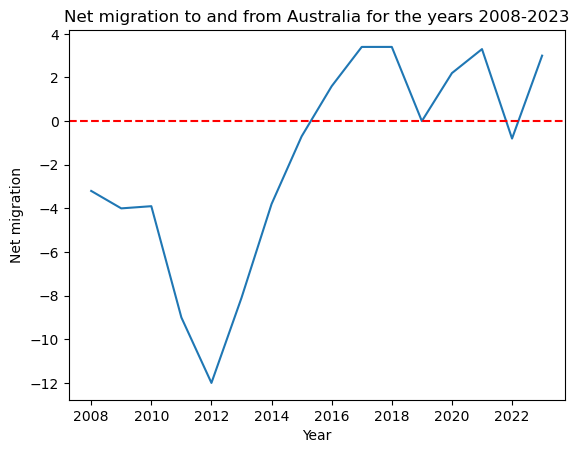

In [27]:
sns.lineplot(x='year', y='total_migration', data=australia_data)
plt.axhline(y=0, color='r', linestyle='--', label='net migration = 0')
plt.xlabel('Year')
plt.ylabel('Net migration')
plt.title('Net migration to and from Australia for the years 2008-2023')

plt.show()

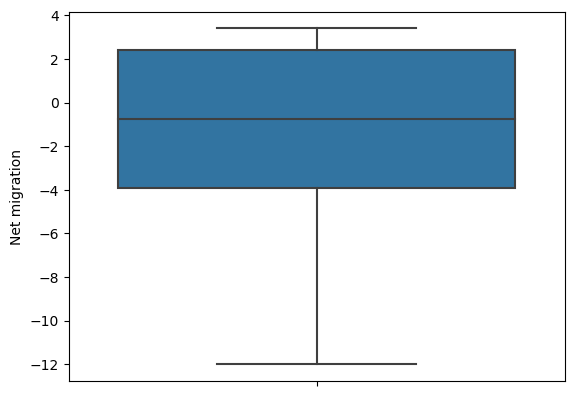

In [28]:
sns.boxplot(data=australia_data, y='total_migration')
plt.ylabel('Net migration')
plt.show()


In [29]:
australia_data['total_migration'].describe()

count    16.000000
mean     -1.787500
std       4.809141
min     -12.000000
25%      -3.925000
50%      -0.750000
75%       2.400000
max       3.400000
Name: total_migration, dtype: float64

In [30]:
australia_2 = (pop_data['country'] == 'Australia') & (pop_data['migration_type'] == 'Emigration') & (pop_data['sex'] == 'Both sexes')
australia_3 = (pop_data['country'] == 'Australia') & (pop_data['migration_type'] == 'Immigration') & (pop_data['sex'] == 'Both sexes')

emigrant_to_aus = pop_data[australia_2]
immigrant_from_aus = pop_data[australia_3]

#emigrant_to_aus
#immigrant_from_aus      # checking to see if NaN values are pre-2008 - they are, so I can drop missing values

emigrant_to_aus = emigrant_to_aus.dropna()
immigrant_from_aus = immigrant_from_aus.dropna()

print("The average number of emigrants to Australia from Ireland is", emigrant_to_aus['total_migration'].mean(), '\nand the average number of immigrants from Australia to Ireland is', immigrant_from_aus['total_migration'].mean())

The average number of emigrants to Australia from Ireland is 8.09375 
and the average number of immigrants from Australia to Ireland is 6.30625


<summary style="color:DarkRed;">

#### Analysis of the above:

There is only data available that covers the period April of 2007 (reported as 2008) until April of 2023 (Reported as 2023). 

For ease of interpreting, a line has been added to the lineplot which indicates where net migration would = 0. This better visualises how immigration from Ireland is on the rise after so much emigration from the period 2008-2012. Given the amount that emigrated, this increase in net migration is likely people returning to Ireland. This is interesting, as it shows the cyclical nature of migration/
    
However, this brief glimpse doesn't capture the total number of migrants to/from Ireland, so I included the print statements. This information isn't significant unless I look at similar data related other countries.

<summary style="color:blue;">

# 3. Continuing inspection of the dataset's features   
    
</summary>

I've been learning Python on Codecademy.com, and one of the concepts covered was boolean masks, so I made use of that knowledge for this task. These work by assigning each row with a true or false based on whether or not a condition is true (i.e. in this case, if the data refers to net migration, and then for both sexes). Then I can create a new dataframe with this info. I also used this approach in Section 2.6 and 2.6.1. **To address missing values, I decided in Section 2.6 that I would ignore missing values instead of deleting any data with NaN values, and focus my anlaysis on areas where there is a complete set of data available.**
    

<summary style="color:blue;">

#### 3.1 Looking at the values I suspect are the sum of the other values in their respective columns:

###### 3.1.1 "All countries"    
</summary>

Concerned about "All countries" under the Country column, is it a total? 
First, I created a new dataframe called `checking_pop_data` to isolate the data for a particular year, choosing a recent year as the data is most likely to have no missing values. But, I still ran `.info()` to confirm. Then I proceeded to make sure to  check the totals for "All countries" vs the total of the other countries. To do this, I looped through each country to sum the total migration value, and to compare it to the value for "all countries":     
    

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>Failed code, for my own reference, so I don't make the same silly mistakes</i></summary>
Below are all my failed attempts at trying to isolate the column - I realised I was overthinking it and went back to basics (in the code block below). All of these obviously failed as I wasn't sure what I was doing and was overcomplicating. 


`print((pop_data['Year'] == 2020))`
      

`for year in pop_data['Year']:`\
    `if year == 2020:`\
    `print(pop_data['Country'], pop_data['VALUE'])`
            
`pop_data.loc[2020:2021, 'Country':'VALUE']`
    
`pop_data.loc[pop_data['Year' == 2020]]`
    
`pop_data.loc['Year', 2020]`
    


</details>

In [31]:
checking_pop_data = pop_data[pop_data['year'] == 2020]
# checking_pop_data.info()

From the above, 

In [32]:
Countries = ['UK', 'USA', 'Canada', 'Australia', 'Other countries', 'EU14 (Excl UK, IRE)', 'EU15 to EU27']

sum_countries = 0
sum_all_countries = 0


for index, row in checking_pop_data.iterrows():
    if row['country'] in Countries:
        sum_countries += row['total_migration']
    elif row['country'] == 'All countries':
        sum_all_countries += row['total_migration']
        
print("Sum for selected countries:", sum_countries)
print("Sum for 'all countries':", sum_all_countries)

Sum for selected countries: 382.4
Sum for 'all countries': 382.4


I'm satisfied that this confirms that the data for "All countries" is the sum of all of the other countries in the dataset.
    
To explain the loop I wrote, I first defined two variables to store the sum of the total_migration values for both "All countries" and all of the other countries. Then, I used `.iterrows()` from pandas to iterate through each row. I was inspired by the answer to <a href="https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas">this post</a>  on stackoverflow, and added my own code after it.

<summary style="color:blue;">

###### 3.1.2 "Both sexes" 

    
</summary>

The same as above, but I'm checking to see if "Both sexes" is the sum of the "Male" and "Female" migration count. (Safe to assume yes, but better safe than sorry). I just adapted the code above and this served as confirmation that "both sexes" is the sum of the values for male and female.

In [33]:
sexes = ['Male', 'Female']
individual_sexes = 0
both_sexes = 0

for index, row in checking_pop_data.iterrows():
    if row['sex'] in sexes:
        individual_sexes += row['total_migration']
    elif row['sex'] == 'Both sexes':
        both_sexes += row['total_migration']
        
print("Sum for individual sexes:", individual_sexes)
print("Sum for both sexes:", both_sexes)

Sum for individual sexes: 382.40000000000003
Sum for both sexes: 382.4


<summary style="color:blue;">

#### 3.2 Looking at migration vs sex

</summary>    
    
Initial thoughts and overview: This dataset is a count of the total number of emigrants and immigrants in any given year, to and from a given county. It's a bit inconvenient to have the net migration plus the number of immigrants and emigrants in the same column I think, but I should be able to find a work around without making additional unnecessary columns. But first, I want to make use of the three types of `migration_type` and visualise them.
    
I was doing this manually in the subsections below, but I was repeating a lot of code so I decided to attempt to write a function to clean it up a bit. I left _Section 4.1.1_ as it is so I can compare the output from my function to it, and then I can speed up the rest of the comparisons. This will be useful as there's countless ways I could explore my data, so being able to isolate it quickly and easily will be beneficial.
     


In [34]:
def filter_migration(dataframe, sex_to_filter, migration_type_to_filter, countries_to_filter):
    specific_sex = dataframe["sex"].isin(sex_to_filter)
    specific_migration_type = dataframe["migration_type"].isin(migration_type_to_filter)
    specific_countries = dataframe["country"].isin(countries_to_filter)
    filtered_data = (dataframe[specific_sex & specific_migration_type & specific_countries])
    return filtered_data

<summary style="color:blue;">

###### 3.2.1 Net Migration for Both Sexes, for each country

</summary>

The first area that I'll focus on is "Net migration" for each country. While I'd rather look at the "all countries" value first, I'd like to try to validate my function, as looking at all countries is a little more complicated given all the strings for `country` that I'll have to include when calling the function. 
    
First, I will test my function, and save it to a variable `net_migration_both_sexes`, and then create a dataframe manually to ensure the function is working okay:

In [35]:
# creating the dataset using the function

net_migration_both_sexes = filter_migration(pop_data, sex_to_filter=["Both sexes"], 
                                            migration_type_to_filter=["Net migration"], 
                                            countries_to_filter = ['UK','USA','Canada','Australia','Other countries','EU14 (Excl UK, IRE)','EU15 to EU27'])

#net_migration_both_sexes.head()
#net_migration_both_sexes.info()

In [36]:
# creating the dataset manually

net_migration = (pop_data["migration_type"] == "Net migration")  
both_sexes = (pop_data["sex"] == "Both sexes") 
countries_for_inclusion = (pop_data["country"] != "All countries") 
net_migration_both_sexes_manual = pop_data[net_migration & both_sexes & countries_for_inclusion]

#net_migration_both_sexes_manual.head()
#net_migration_both_sexes_manual.info()

There's probably no need to reset the index using `.reset_index()` on the output, but I may change my mind later. I used .info() and /head() to verify the output, and noting the number of rows etc. Creating the dataframe manually to ensure my function works okay is probably unnecessary as I'm using similar code, but I would prefer to be safe than sorry.
    
They seem similar, but I'll use `.equals()` to checks if the two datasets are identical based on the output (either True or False): <a href="https://towardsdatascience.com/3-easy-ways-to-compare-two-pandas-dataframes-b2a18169c876#:~:text=Compare%20Pandas%20DataFrames%20using%20equals(),-Pandas%20offer%20an&text=DataFrame.,data%20at%20the%20same%20position.">source</a>    

In [37]:
net_migration_both_sexes.equals(net_migration_both_sexes_manual)

True

<summary style="color:darkred;"> 

I'm satisfied that my formula works, so I'll apply it in subsequent subsections when filtering data.
    
</summary>     

I decided to use a barchart to visualise the data, as I'm looking at multiple different countries. This is the easiest and most accessible way for the viewer to interpret and compare the net migration. I used .groupby() to apply an aggregate function, so that I could get the mean of the net migration for each country.

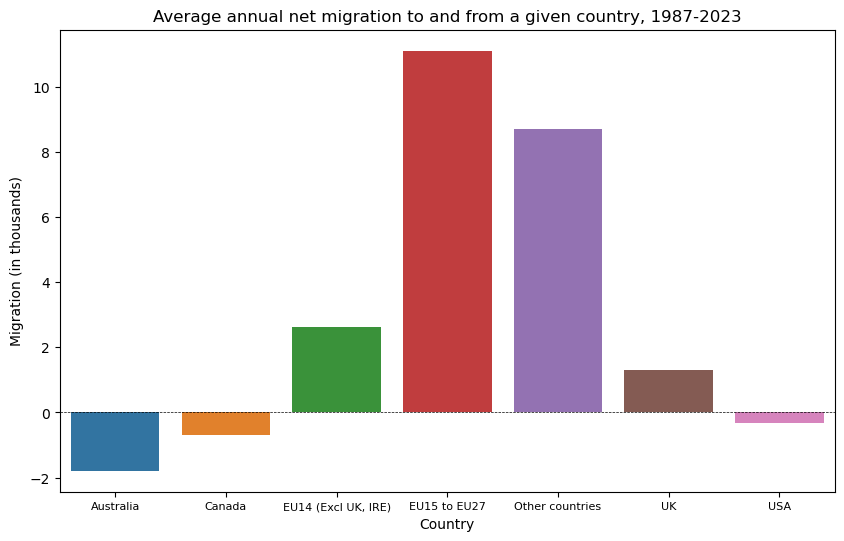

In [38]:
mean_migration_by_country = net_migration_both_sexes.groupby('country')['total_migration'].mean().reset_index()

plt.figure(figsize=(10, 6))      # approx 3:2 aspect ratio
sns.barplot(x='country', y='total_migration', data=mean_migration_by_country)
plt.xlabel('Country')
plt.ylabel('Migration (in thousands)')
plt.title('Average annual net migration to and from a given country, 1987-2023')
plt.xticks(fontsize=8)      # the labels overlap so I have to make the font smaller
plt.axhline(y=0, color='k', label='y=0', linestyle = '--', linewidth = 0.5)      # horizontal line noting where the axis is
plt.show()

Negative net migration indicates that more people emigrated from Ireland to the country than immigrated from that country. However, this information is skewed, as "other countries" probably contains the migration info from Australia, Canada and EU 15 to EU 27 before they were included as separate labels, around 2008 (as discovered in section 2.6). Therefore, I'll split this into 1986 to 2007, and 2008 to present. The other option would be to add the migration total from Australia, Canada and EU 15 to EU 27 to the "Other countries" so I could have one graph represent everything to present, but I feel like I'd lose important information. I also think this split is valid because of the downturn in Ireland's economy in 2008, so it'll be interesting to see the comparisons.

I realised afer I generated the graph for pre-2008 that there was data available for 'EU15 to EU27' from 2005 onwards, so I rewrote the code to include 'EU15 to EU27' under 'Other countries'. I was initially going to simply rename the former column but realised this would mess up the mean values. I was struggling to first pivot it and call .sum() using .groupby(). So I went through a long-winded process, first filtering, then pivoting, then adding a new column with the sums of the migration values for 'EU15 to EU27' and 'Other countries'. I was unsure how to merge this data with the original dataset, as I want to replace the previous values for  'Other countries' with the new values obtained. I ended up doing it manually, as it was only 3 values that needed to be changed, but I wouldn't do this if it was a larger dataframe. I was careful to use .loc() to change the values in case I accidentally changed additional values by using .replace for all instances of a value.
After I did this, I plotted the mean migration totals for pre-2008. 

In [39]:
net_migration_both_sexes_to_2007 = net_migration_both_sexes[net_migration_both_sexes['year'] < 2008]
other_countries_filter = net_migration_both_sexes_to_2007[(net_migration_both_sexes_to_2007['country'] == 'Other countries') | (net_migration_both_sexes_to_2007['country'] == 'EU15 to EU27')]

other_countries_pivot = pd.pivot_table(other_countries_filter,
                                       index='year',
                                       columns=['country'],
                                       values='total_migration',
                                       aggfunc='sum'
                                      )

other_countries_pivot['Other countries total'] = other_countries_pivot['EU15 to EU27'] + other_countries_pivot['Other countries']

other_countries_pivot = other_countries_pivot.drop(columns = ['EU15 to EU27', 'Other countries'])
other_countries_pivot = other_countries_pivot.rename(columns = {'Other countries total':'Other countries'})
other_countries_pivot = other_countries_pivot.melt()
#other_countries_pivot

In [40]:
#replacing the values:
net_migration_both_sexes_to_2007.loc[(net_migration_both_sexes_to_2007['country']=='Other countries')&(net_migration_both_sexes_to_2007['year']==2005),'total_migration'] = 39.6
net_migration_both_sexes_to_2007.loc[(net_migration_both_sexes_to_2007['country']=='Other countries')&(net_migration_both_sexes_to_2007['year']==2006),'total_migration'] = 54.5
net_migration_both_sexes_to_2007.loc[(net_migration_both_sexes_to_2007['country']=='Other countries')&(net_migration_both_sexes_to_2007['year']==2007),'total_migration'] = 78.8
net_migration_both_sexes_to_2007=net_migration_both_sexes_to_2007[net_migration_both_sexes_to_2007['country'] != 'EU15 to EU27']
net_migration_both_sexes_to_2007=net_migration_both_sexes_to_2007.dropna()
#net_migration_both_sexes_to_2007 #finally ready for visualisation

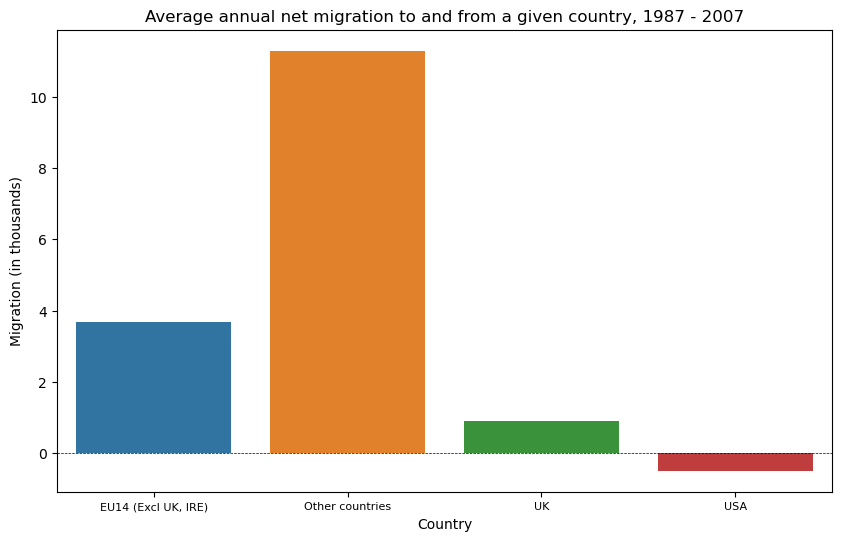

In [41]:
mean_migration_by_country_to_2007 = net_migration_both_sexes_to_2007.groupby('country')['total_migration'].mean().reset_index()

plt.figure(figsize=(10, 6))      # approx 3:2 graphical ratio
sns.barplot(x='country', y='total_migration', data=mean_migration_by_country_to_2007)
plt.xlabel('Country')
plt.ylabel('Migration (in thousands)')
plt.title('Average annual net migration to and from a given country, 1987 - 2007')
plt.xticks(fontsize=8)      # the labels overlap so I have to make the font smaller
plt.axhline(y=0, color='k', label='y=0', linestyle = '--', linewidth = 0.5)      # horizontal line noting where the axis is
plt.show()

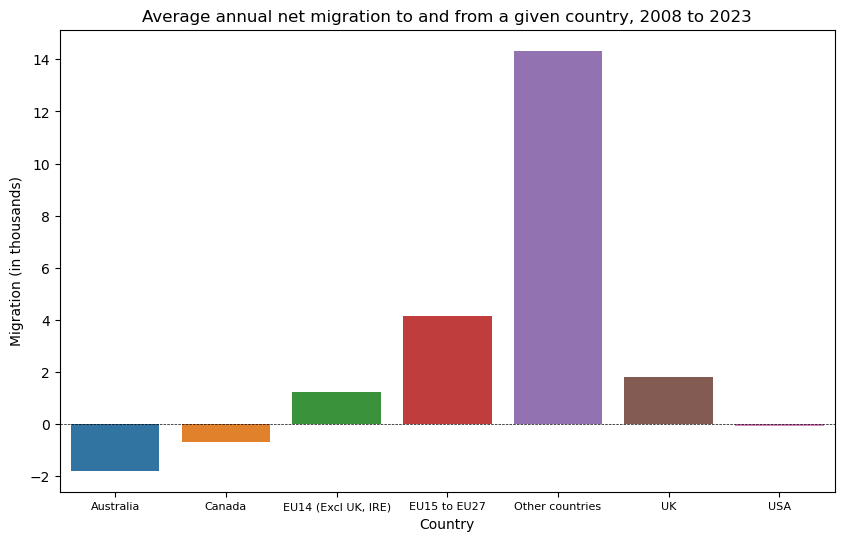

In [42]:
net_migration_both_sexes_from_2008 = net_migration_both_sexes[net_migration_both_sexes['year'] >= 2008]
net_migration_both_sexes_from_2008 = net_migration_both_sexes_from_2008.groupby('country')['total_migration'].mean().reset_index()

plt.figure(figsize=(10, 6))      # approx 3:2 graphical ratio
sns.barplot(x='country', y='total_migration', data=net_migration_both_sexes_from_2008)
plt.xlabel('Country')
plt.ylabel('Migration (in thousands)')
plt.title('Average annual net migration to and from a given country, 2008 to 2023')
plt.xticks(fontsize=8)      # the labels overlap so I have to make the font smaller
plt.axhline(y=0, color='k', label='y=0', linestyle = '--', linewidth = 0.5)      # horizontal line noting where the axis is
plt.show()

<summary style="color:blue;">

###### 3.2.2 Looking at Net Migration for all countries overall for both sexes.

</summary>    
    
I'll use the total values, `'All countries'` and `'Both sexes'`, to get a glimpse at how the data looks overall.
First, I'll call the function to filter the data and move it to a new dataframe. Then, I'll derive some summary statistics.    


In [56]:
overall_net_migration = filter_migration(pop_data, sex_to_filter=["Both sexes"], 
                                            migration_type_to_filter=["Net migration"], 
                                            countries_to_filter = ['All countries'])
#overall_net_migration.info() # there are no missing values

<summary style="color:blue;">

- ***3.2.2.1 Descriptive analysis of the net migration for all countries for both sexes***
    
</summary>

This is the first meaningful statistic that has been derived, as there's no missing values, and no additional summary values that skew the `total_migration` values. Also, there's no need to call `.describe(include='object')` as there's nothing additional that can be derived for the other variables, as there's only one unique value for each. 
    
The first thing I've noticed is that the mean is similar to the median (16941 vs 17300), but it's not identical and is slightly skewed. The 25th percentile is less than the median, and the 75th percentile is greater than the median. This suggests that the data has a longer right tail, which implies that this is data is right-skewed. I can use a histogram to visualise this.
The data ranges from -43,900 to 104,800.
Also, the standard deviation is large, which suggests a high variability.
Out of sheer interest, I would like to see which row had such a high migration;        

In [44]:
overall_net_migration['total_migration'].describe()

count     37.000000
mean      16.940541
std       34.755803
min      -43.900000
25%       -4.700000
50%       17.300000
75%       41.300000
max      104.800000
Name: total_migration, dtype: float64

In [45]:
max_value = overall_net_migration[overall_net_migration['total_migration'] == overall_net_migration['total_migration'].max()]
min_value = overall_net_migration[overall_net_migration['total_migration'] == overall_net_migration['total_migration'].min()]
print("Highest level of migration into Ireland:\n", max_value, "\n")
print("Highest level of migration from Ireland:\n", min_value)

Highest level of migration into Ireland:
       year        country         sex migration_type  total_migration
1485  2007  All countries  Both sexes  Net migration            104.8 

Highest level of migration from Ireland:
      year        country         sex migration_type  total_migration
189  1989  All countries  Both sexes  Net migration            -43.9


Text(0.5, 1.0, 'Annual net migration to and from Ireland, 1987 to 2023')

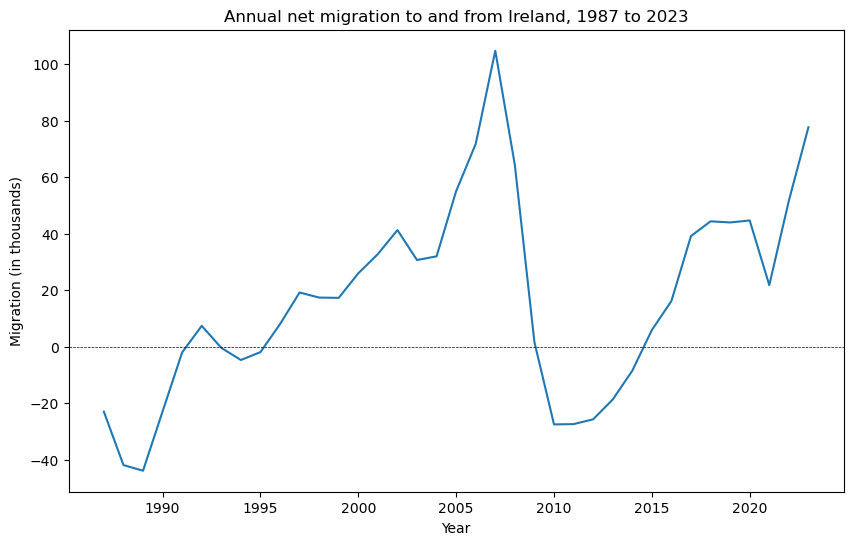

In [46]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=overall_net_migration, x='year', y='total_migration')
plt.xlabel('Year')
plt.ylabel('Migration (in thousands)')
plt.axhline(y=0, color='k', label='y=0', linestyle = '--', linewidth = 0.5)
plt.title('Annual net migration to and from Ireland, 1987 to 2023')

The year that the most migrated into Ireland is interesting - particularly as 2007 is just before the recession? Might look into this further later or discuss _briefly_ in the report?
    
Below, I plotted a histogram to see the distribution of overall_net_migration using the seaborn package, as it's easier to work with than matplotlib, particularly as it automatically calculates an appropriate number of bins. I set the kernel density estimation, `kde`, to False as it wasn't needed in this instance, as I'm just looking at this one histogram at the moment. I played around with the number of bins but left it as the default, and noticed that it was the same as when I used the square-root rule to calculate the appropriate number of bins with `n_bins = int(np.sqrt(len(overall_net_migration)))`.

Text(0.5, 1.0, 'Histogram for the net migration in and out of Ireland, 1987-2023')

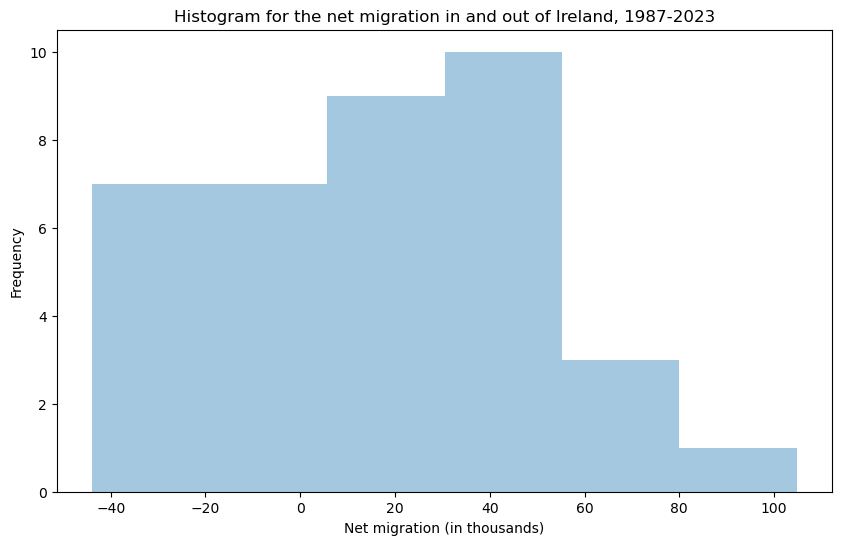

In [57]:
plt.figure(figsize=(10, 6))
sns.distplot(overall_net_migration['total_migration'], kde=False);
plt.xlabel('Net migration (in thousands)')
plt.ylabel('Frequency')
plt.title('Histogram for the net migration in and out of Ireland, 1987-2023')

<summary style="color:darkred;">

It's clear from the above that the data is right-skewed. I didn't log transform this histogram as it's only slightly skewed, and also there are negative values, so log transforming shouldn't be used anyway. 
    

<summary style="color:blue;">

- ***3.2.2 Net migration type for individual sexes, for all countries***
    
</summary>

There won't be missing values as I'm using `"All countries"`, so I can look at the full year range for the dataset. Interesting that the net migration for females is higher than males, this can mean either more women come to Ireland or more men leave Ireland. Might have to break down emigration vs immigration for each sex as well. I visualised this on a lineplot below. More women came to Ireland in the data published for April 2023 as can be seen in this graph - Ukraine conflict may have a role in that.

In [77]:
net_individual_sex_all_country = filter_migration(pop_data, sex_to_filter=["Male", "Female"],migration_type_to_filter=["Net migration"], countries_to_filter = ['All countries'])
net_individual_sex_all_country_f = filter_migration(pop_data, sex_to_filter=["Female"],migration_type_to_filter=["Net migration"],countries_to_filter = ['All countries'])
net_individual_sex_all_country_m = net_individual_sex_all_country = filter_migration(pop_data, sex_to_filter=["Male"],migration_type_to_filter=["Net migration"],countries_to_filter = ['All countries'])

print('The mean net migration for females is', round(net_individual_sex_all_country_f['total_migration'].mean() * 1000), 
      '\nThe mean net migration for males is', round(net_individual_sex_all_country_m['total_migration'].mean() * 1000))

The mean net migration for females is 8208 
The mean net migration for males is 7373


Text(0.5, 1.0, 'Annual net migration to and from Ireland by sex, 1987 to 2023')

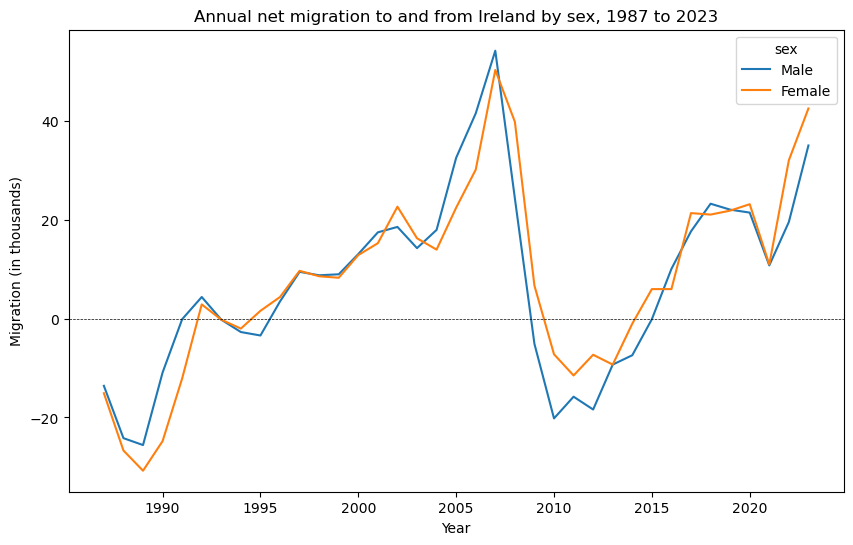

In [65]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=net_individual_sex_all_country, x='year', y='total_migration', hue="sex", legend='brief')
plt.xlabel('Year')
plt.ylabel('Migration (in thousands)')
plt.axhline(y=0, color='k', label='y=0', linestyle = '--', linewidth = 0.5)
plt.title('Annual net migration to and from Ireland by sex, 1987 to 2023')

<summary style="color:blue;">

- ***3.2.2 Each migration type for individual sexes, for all countries***
    
</summary>  

As there will be missing values for this dataset, I will focus on data from 2008 onwards.

In [128]:
migration_individual_sex_all_country = filter_migration(pop_data, sex_to_filter=["Male", "Female"],migration_type_to_filter=["Emigration", "Immigration"], countries_to_filter = ['All countries'])
migration_individual_sex_all_country_f = filter_migration(pop_data, sex_to_filter=["Female"],migration_type_to_filter=["Emigration", "Immigration"],countries_to_filter = ['All countries'])
migration_individual_sex_all_country_m = net_individual_sex_all_country = filter_migration(pop_data, sex_to_filter=["Male"],migration_type_to_filter=["Emigration", "Immigration"],countries_to_filter = ['All countries'])

migration_individual_sex_all_country = migration_individual_sex_all_country[migration_individual_sex_all_country['year'] >= 2008]
migration_individual_sex_all_country.describe(include='object')

migration_individual_sex_all_country_f = migration_individual_sex_all_country_f[migration_individual_sex_all_country_f['year'] >= 2008]
migration_individual_sex_all_country_m = migration_individual_sex_all_country_m[migration_individual_sex_all_country_m['year'] >= 2008]

Text(0.5, 1.0, 'Average migration to and from Ireland by sex, 2008 to 2023')

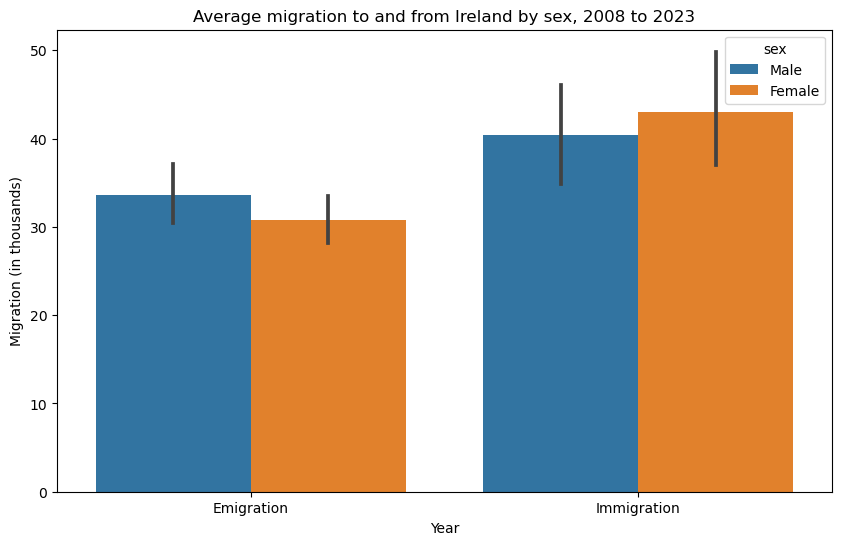

In [129]:
#have to run this next line because sns was interpretting "Net migration" as acategory despite it being empty of values.
migration_individual_sex_all_country['migration_type'] = migration_individual_sex_all_country['migration_type'].astype('object')

plt.figure(figsize=(10, 6))
sns.barplot(data=migration_individual_sex_all_country, x='migration_type', y='total_migration', hue="sex") 
plt.xlabel('Year')
plt.ylabel('Migration (in thousands)')
plt.title('Average migration to and from Ireland by sex, 2008 to 2023')

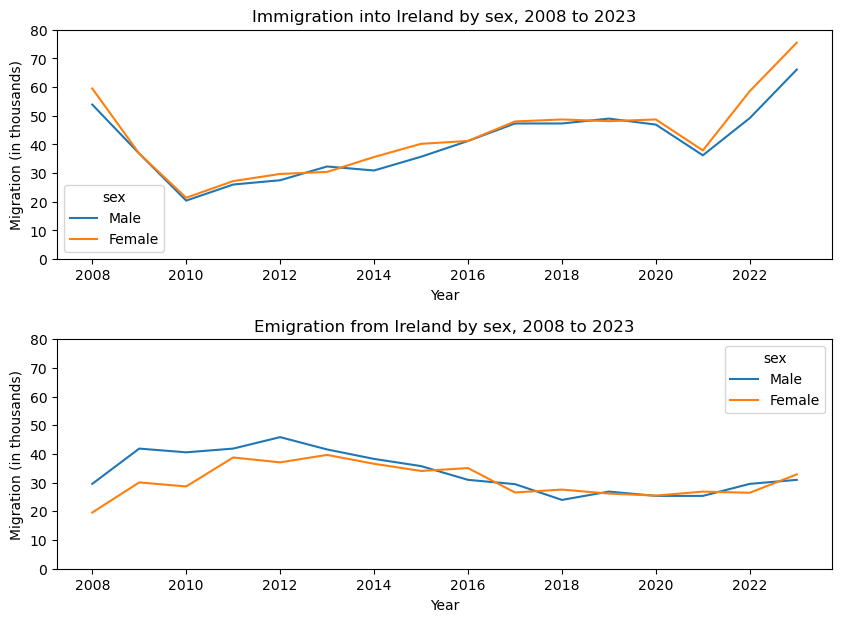

In [148]:
emigration_individual_sex_all_country = migration_individual_sex_all_country[migration_individual_sex_all_country['migration_type']=="Emigration"]
immigration_individual_sex_all_country = migration_individual_sex_all_country[migration_individual_sex_all_country['migration_type']=="Immigration"]

plt.figure(figsize=(10, 7))

# Subplot 1
plt.subplot(2, 1, 1)
sns.lineplot(data=immigration_individual_sex_all_country, x='year', y='total_migration', hue="sex")
plt.xlabel('Year')
plt.ylabel('Migration (in thousands)')
plt.ylim(0, 80)
plt.title('Immigration into Ireland by sex, 2008 to 2023')


# Subplot 2
plt.subplot(2, 1, 2)
sns.lineplot(data=emigration_individual_sex_all_country, x='year', y='total_migration', hue="sex")
plt.xlabel('Year')
plt.ylabel('Migration (in thousands)')
plt.ylim(0, 80)
plt.title('Emigration from Ireland by sex, 2008 to 2023')

plt.subplots_adjust(hspace=0.35)

I set the a range for y axis of the plots above so they can be easily compared and interpretted by the viewer. I also altered the aspect slightly so that the graphs aren't as stretched. Interesting that Emigration has remained fairly constant, and initially a much higher proportion of males than females emigrated, but now for the past decade the'yve been similar.
Immigration into Ireland has skyrocked to 2007 levels (reminder: `year` refers to the year the information was published, and coveres the period April of the previous year to April of that year). Immigration is at the levels it was in 2007 when the economy seemed to be booming and there was a massive influx of people into Ireland. The sudden high levels is likely a result of the Ukraine conflict.

<summary style="color:blue;">
    
# 4. Statistical analysis

could look at which country someone is most likely to emigrate to?

In [55]:
#this is for looking a countries individually for each country 
net_migration_individual_sex = filter_migration(pop_data, sex_to_filter=["Male", "Female"], 
                                                migration_type_to_filter=["Net migration"], 
                                                countries_to_filter = ['UK','USA','Canada','Australia','Other countries','EU14 (Excl UK, IRE)','EU15 to EU27'])

net_migration_individual_sex = net_migration_individual_sex[net_migration_individual_sex['year'] >= 2008]


<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 1515 to 2661
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   year             224 non-null    int64   
 1   country          224 non-null    object  
 2   sex              224 non-null    object  
 3   migration_type   224 non-null    category
 4   total_migration  224 non-null    float64 
dtypes: category(1), float64(1), int64(1), object(2)
memory usage: 9.1+ KB
